# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем все необходимые библиотеки и датасеты

In [202]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from numpy.random import RandomState
from scipy import stats as st
from matplotlib import pyplot

In [203]:
df_0 = pd.read_csv('datasets/geo_data_0.csv')
df_1 = pd.read_csv('datasets/geo_data_1.csv')
df_2 = pd.read_csv('datasets/geo_data_2.csv')

#создаем библиотеку для удобства пользования
dfs = {
    'df_0': df_0,
    'df_1': df_1,
    'df_2': df_2
}

#разберем структуру и основные метрики
for element in dfs:
    df = dfs[element]
    print(element)
    print(df.info())
    print('дубликатов', df.duplicated().sum())
    display(df.corr())
    print()

df_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
дубликатов 0


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000



df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
дубликатов 0


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000



df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
дубликатов 0


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Вывод**   
- Каждая из выборок состоит из 100,000 наблюдений.
- Все переменные, кроме id месторождения, числовые.
- Пропусков и дубликатов нет.
- Для данных по месторождению из файла geo_data_1 наблюдается практически функциональная зависимость между product и фактором f2.  
- Мультиколлинеарности факторов не обнаружено.

## Обучение и проверка модели

### Разделение на выборки

Разобьем выборки на обучающие и валидационные для каждого из датасетов.

In [204]:
samples = {'df_0': {},
          'df_1': {},
          'df_2': {}}

x = 0
for element in dfs:
    df = dfs[element]
    df_train, df_valid = train_test_split(df, test_size=0.25, random_state=12345)
    samples[f'df_{x}']['target_train'] = df_train['product']
    samples[f'df_{x}']['target_valid'] = df_valid['product']
    samples[f'df_{x}']['features_train'] = df_train.drop(['product', 'id'], axis=1)
    samples[f'df_{x}']['features_valid'] = df_valid.drop(['product', 'id'], axis=1)
    x += 1

### Расчет моделей

In [205]:
#для каждого региона рассчитаем модель, предсказания, а также ключевые характеристики
x = 0
for element in samples:
    df = samples[element]
    model = LinearRegression()
    model.fit(df['features_train'], df['target_train'])  
    df['predicted'] = pd.Series(model.predict(df['features_valid']), index=df['target_valid'].index)    
    mse = mean_squared_error(df['target_valid'], df['predicted'])
    rmse = mse ** 0.5
    r2 = r2_score(df['target_valid'], df['predicted'])
    avg = df['predicted'].mean()
    print(f'df_{x}')
    print(f'средний запас - {avg:.2f}')
    print(f'rmse: {rmse:.2f}')
    print(f'r2: {r2:.2f}')
    print()
    x += 1

df_0
средний запас - 92.59
rmse: 37.58
r2: 0.28

df_1
средний запас - 68.73
rmse: 0.89
r2: 1.00

df_2
средний запас - 94.97
rmse: 40.03
r2: 0.21



**Вывод**   
Как было понятно и из корреляционного анализа, наименьший rmse и наибольший r2 продемонстрировала модель на данных месторождения df_0. На оставшихся датасетах получены достаточно низкие значения r2 с большой степенью разброса (rmse ~ 40).

## Подготовка к расчёту прибыли

In [206]:
#ключевые параметры
budget = 10000000000
profit_product = 450000
borehole_number = 200

break_even = budget / (profit_product * borehole_number)
print(f'Точка безубыточности: {break_even:.2f}')

Точка безубыточности: 111.11


**Вывод**   
Точка безубыточности выше для каждого из оцененных средних на этапе построения модели по регионам.

## Расчёт прибыли и рисков 

### Расчет прибыли

In [207]:
#сформируем датасеты для дальнейшего подсчета прибыли
dfs_profit = {
    'df_0': [],
    'df_1': [],
    'df_2': []
}
x=0
for element in samples:
    dfs_profit[f'df_{x}'] = pd.DataFrame([samples[element]['target_valid'], samples[element]['predicted']]).transpose()
    dfs_profit[f'df_{x}'].columns=['product', 'predicted']
    x+=1

#определим функцию прибыли
def profit(df):    
    sample_500 = df.sample(frac=500/len(df), random_state=12345)
    sample_200 = sample_500.sort_values(by='predicted', ascending=False)[:borehole_number]
    barrels = sample_200['product'].sum()
    profit = barrels * profit_product - budget
    return profit

#посчитаем прибыль для каждого региона
x = 0
for element in dfs_profit:
    p_l = profit(dfs_profit[element]) / 1000000000
    print(f'Прибыль региона {x}: {p_l:.3f} млрд.')
    x += 1

Прибыль региона 0: 0.679 млрд.
Прибыль региона 1: 0.779 млрд.
Прибыль региона 2: 0.440 млрд.


**Вывод**   
Наибольшая ожидаемая прибыль у второго месторождения.

### Построение распределения прибыли

df_0
Среднее - 0.385
Доверительный интервал 95%: (0.3694580246741764, 0.4004373491036672)
Риск убытка 5.8%


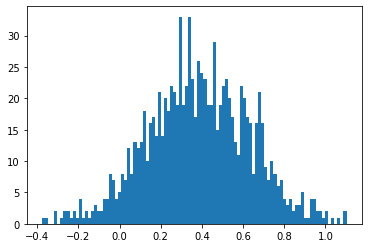

df_1
Среднее - 0.444
Доверительный интервал 95%: (0.4310591186657529, 0.4563718446557012)
Риск убытка 1.8%


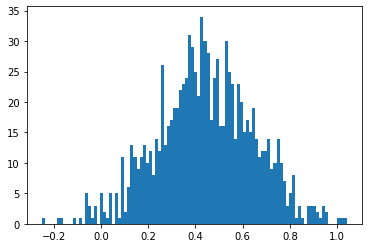

df_2
Среднее - 0.394
Доверительный интервал 95%: (0.37839140657199527, 0.4105993975382198)
Риск убытка 6.1%


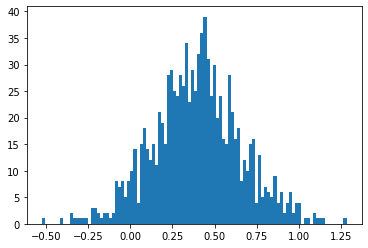

In [208]:
bootstrap_samples = 1000

def profit_pool(df_profit):
    profit_values = []
    state = RandomState(12345)
    for i in range(bootstrap_samples):
        #поскольку месторождение не может разрабатываться дважды, определим параметр замены как False
        df_profit_new = df_profit.sample(frac=1, replace=False, random_state=state)
        profit_values.append(profit(df_profit_new))
    return pd.Series(profit_values)

#построим распределение и посчитаем основные метрики
x=0    
for element in dfs_profit:
    print(f'df_{x}')
    profits = profit_pool(dfs_profit[element]) / 1000000000
    print(f'Среднее - {profits.mean():.3f}')
    confidence_interval = st.t.interval(alpha=0.95, df=len(profits)-1, loc=profits.mean(), scale=profits.sem())
    print(f'Доверительный интервал 95%: {confidence_interval}')
    loss_share = profits[profits < 0].count() / 1000
    print(f'Риск убытка {loss_share:.1%}')
    pyplot.hist(profits, bins=100)
    pyplot.show()
    x += 1

**Вывод**   
Месторождение df_1 выглядит наиболее привлекательным по ряду причин:
1. Максимальная ожидаемая прибыль (как на этапе оценки модели, так и на этапе бутстрэпинга).
2. Модель наиболее управляемая и предсказуемая. Если есть информация об одном из параметров, то можно предсказать добычу с точностью до 99%.
3. Нижняя граница доверительного интервала превышает верхние границы ДИ остальных регионов.
4. Риск получения убытков минимален по сравнению с остальными регионами.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован